<a href="https://colab.research.google.com/github/marcelogarret/rna/blob/main/aula10a_forecasting_garret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-05-04 16:00:18--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-05-04 16:00:19 (38.0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



**Dataset Passageiros de Companhias Aéreas**

Registra o número mensal em milhares de passageiros de companhias aéreas dos EUA de 1949 a 1960. É uma série temporal clássica que é geralmente usada para testar métodos de previsão de séries temporais

**Parâmetros do Dataset**

1.   **sequence_length**:  são utilizados 12 meses (1 ano) de dados para prever o número de passageiros no próximo mês. Isso permite capturar a sazonalidade anual, uma característica importante deste dataset.
2.   **sampling_rate**: Cada registro mensal será considerado, sem pular meses, para preservar a continuidade sazonal.
3.   **delay**: A previsão será feita para o mês subsequente, adequada para planejamento e alocação de recursos.

In [16]:
import numpy as np

raw_data = []
with open("airline-passengers.csv") as f:
    f.readline()  # Pula o cabeçalho
    for line in f:
        fields = line.split(',')
        raw_data.append(float(fields[1]))  # Assume que a segunda coluna é o número de passageiros

raw_data = np.array(raw_data)
print("Número total de pontos:", len(raw_data))

Número total de pontos: 144


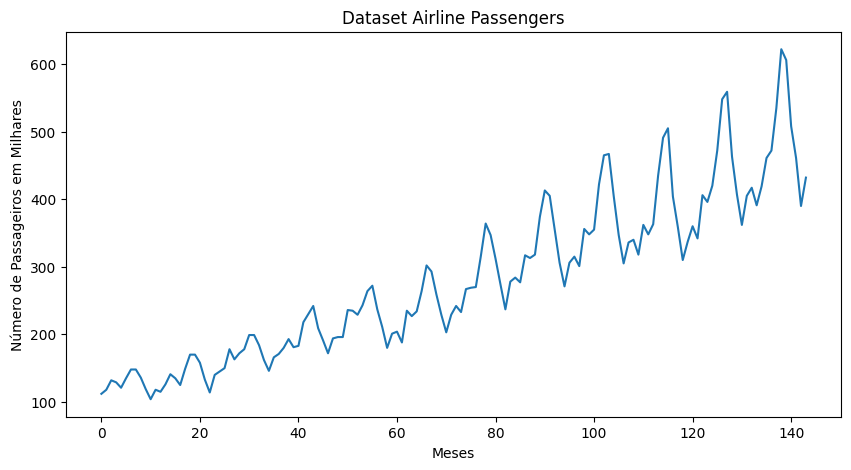

In [17]:
from matplotlib import pyplot as plt

# Gráfico para visualizar dados
plt.figure(figsize=(10, 5))
plt.plot(range(len(raw_data)), raw_data)
plt.title("Dataset Airline Passengers")
plt.xlabel("Meses")
plt.ylabel("Número de Passageiros em Milhares")
plt.show()

In [20]:
num_train_samples = int(0.75 * len(raw_data))
num_val_samples = int(0.125 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(108, 18, 18)

In [21]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [22]:
train_data = raw_data[:num_train_samples]
val_data = raw_data[num_train_samples:num_train_samples + num_val_samples]
test_data = raw_data[num_train_samples + num_val_samples:]

In [23]:
from tensorflow import keras

# Parâmetros para a criação do dataset
sequence_length = 12  # 12 meses para previsão
sampling_rate = 1     # Cada mês é considerado
delay = 1             # Previsão para o próximo mês

train_dataset = keras.utils.timeseries_dataset_from_array(
    train_data[:-delay],
    targets=train_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=128,
    shuffle=True
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    val_data[:-delay],
    targets=val_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=128,
    shuffle=True
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    test_data[:-delay],
    targets=test_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=128,
    shuffle=True
)

In [24]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (96, 12)
targets shape (96,)


#baseline

In [56]:
# Avaliação ingênua (Naive)
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1] # A última observação é usada como previsão
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 0.35
Test MAE: 1.20


#densely conected

In [57]:
from tensorflow.keras import layers

# Dado que estamos tratando de uma série univariada, `raw_data.shape[-1]` é 1
# Configurando o modelo de rede neural
inputs = keras.Input(shape=(sequence_length, 1))  # Modificado para refletir a única série de entrada
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Callback para salvar o modelo com o melhor desempenho baseado no conjunto de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_dense.keras",
                                    save_best_only=True)
]

# Compilação do modelo com otimizador RMSprop, função de perda MSE e acompanhamento do MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_dense.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 1s 730ms/step - loss: 0.6926 - mae: 0.6907 - val_loss: 1.4890 - val_mae: 0.9525
Epoch 2/10
1/1 [==============================] - 0s 96ms/step - loss: 0.6215 - mae: 0.6617 - val_loss: 1.3845 - val_mae: 0.9272
Epoch 3/10
1/1 [==============================] - 0s 93ms/step - loss: 0.5765 - mae: 0.6382 - val_loss: 1.3063 - val_mae: 0.9076
Epoch 4/10
1/1 [==============================] - 0s 92ms/step - loss: 0.5421 - mae: 0.6192 - val_loss: 1.2428 - val_mae: 0.8894
Epoch 5/10
1/1 [==============================] - 0s 105ms/step - loss: 0.5136 - mae: 0.6026 - val_loss: 1.1875 - val_mae: 0.8725
Epoch 6/10
1/1 [==============================] - 0s 95ms/step - loss: 0.4885 - mae: 0.5876 - val_loss: 1.1371 - val_mae: 0.8559
Epoch 7/10
1/1 [==============================] - 0s 91ms/step - loss: 0.4662 - mae: 0.5737 - val_loss: 1.0907 - val_mae: 0.8398
Epoch 8/10
1/1 [==============================] - 0s 96ms/step - loss: 0.4460 - mae: 0.5607 - v

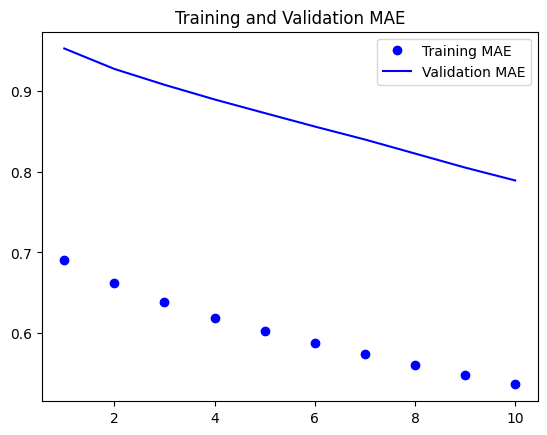

In [58]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

#1D convolutional model

In [68]:
# Ajustando o modelo para evitar a redução excessiva de dimensionalidade
inputs = keras.Input(shape=(sequence_length, 1))  # A entrada ainda espera uma única série temporal por amostra
x = layers.Conv1D(8, 24, activation="relu", padding='same')(inputs)  # Aplicando um Conv1D com 8 filtros de tamanho 24
# x = layers.MaxPooling1D(2)(x)  # Aplicando apenas um pooling para reduzir a dimensionalidade
# x = layers.Conv1D(8, 12, activation="relu", padding='same')(x)  # Aplicando outro Conv1D com 8 filtros de tamanho 12
x = layers.MaxPooling1D(2)(x) # Aplicando apenas um pooling para reduzir a dimensionalidade
x = layers.Conv1D(8, 3, activation="relu", padding='same')(x)  # Mantendo as dimensões com padding 'same'
x = layers.GlobalAveragePooling1D()(x)  # Global average pooling para resumir as características
outputs = layers.Dense(1)(x)  # Camada de saída
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo baseado no desempenho de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_conv_adjusted.keras",
                                    save_best_only=True)
]

# Compilação do modelo
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_conv_adjusted.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7387 - mae: 0.7149 - val_loss: 2.2374 - val_mae: 1.3233
Epoch 2/10
1/1 [==============================] - 0s 97ms/step - loss: 0.6770 - mae: 0.6839 - val_loss: 2.0766 - val_mae: 1.2614
Epoch 3/10
1/1 [==============================] - 0s 103ms/step - loss: 0.6424 - mae: 0.6651 - val_loss: 1.9282 - val_mae: 1.2018
Epoch 4/10
1/1 [==============================] - 0s 101ms/step - loss: 0.6157 - mae: 0.6500 - val_loss: 1.7903 - val_mae: 1.1444
Epoch 5/10
1/1 [==============================] - 0s 96ms/step - loss: 0.5929 - mae: 0.6364 - val_loss: 1.6624 - val_mae: 1.0887
Epoch 6/10
1/1 [==============================] - 0s 112ms/step - loss: 0.5732 - mae: 0.6249 - val_loss: 1.5453 - val_mae: 1.0350
Epoch 7/10
1/1 [==============================] - 0s 139ms/step - loss: 0.5558 - mae: 0.6143 - val_loss: 1.4343 - val_mae: 0.9809
Epoch 8/10
1/1 [==============================] - 0s 104ms/step - loss: 0.5398 - mae: 0.6044 - 

#Rede Recorrente


In [64]:
# Definindo o modelo LSTM para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(64)(inputs)  # Usando uma camada LSTM com 32 unidades
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm.keras",  # Nome alterado para refletir o novo dataset
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e o métrico MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5891 - mae: 0.6392 - val_loss: 2.3226 - val_mae: 1.3573
Epoch 2/10
1/1 [==============================] - 0s 94ms/step - loss: 0.4112 - mae: 0.5302 - val_loss: 1.8996 - val_mae: 1.1914
Epoch 3/10
1/1 [==============================] - 0s 97ms/step - loss: 0.3061 - mae: 0.4498 - val_loss: 1.5908 - val_mae: 1.0544
Epoch 4/10
1/1 [==============================] - 0s 96ms/step - loss: 0.2336 - mae: 0.3830 - val_loss: 1.3494 - val_mae: 0.9339
Epoch 5/10
1/1 [==============================] - 0s 138ms/step - loss: 0.1854 - mae: 0.3275 - val_loss: 1.1529 - val_mae: 0.8233
Epoch 6/10
1/1 [==============================] - 0s 101ms/step - loss: 0.1563 - mae: 0.2938 - val_loss: 0.9946 - val_mae: 0.7486
Epoch 7/10
1/1 [==============================] - 0s 102ms/step - loss: 0.1404 - mae: 0.2797 - val_loss: 0.8743 - val_mae: 0.6895
Epoch 8/10
1/1 [==============================] - 0s 101ms/step - loss: 0.1321 - mae: 0.2763 - v

# dropout-regularized LSTM

In [65]:
# Definindo o modelo LSTM com dropout para prevenção de overfitting
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(64, recurrent_dropout=0.25)(inputs)  # Usando LSTM com 64 unidades e dropout recorrente
x = layers.Dropout(0.5)(x)  # Dropout após a camada LSTM para reduzir ainda mais o overfitting
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_dropout.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_dropout.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6375 - mae: 0.6663 - val_loss: 2.5021 - val_mae: 1.4283
Epoch 2/10
1/1 [==============================] - 0s 128ms/step - loss: 0.4857 - mae: 0.5694 - val_loss: 2.0667 - val_mae: 1.2664
Epoch 3/10
1/1 [==============================] - 0s 127ms/step - loss: 0.3746 - mae: 0.5006 - val_loss: 1.7499 - val_mae: 1.1344
Epoch 4/10
1/1 [==============================] - 0s 169ms/step - loss: 0.2910 - mae: 0.4276 - val_loss: 1.5172 - val_mae: 1.0271
Epoch 5/10
1/1 [==============================] - 0s 131ms/step - loss: 0.2451 - mae: 0.3779 - val_loss: 1.3366 - val_mae: 0.9354
Epoch 6/10
1/1 [==============================] - 0s 124ms/step - loss: 0.1942 - mae: 0.3428 - val_loss: 1.1815 - val_mae: 0.8491
Epoch 7/10
1/1 [==============================] - 0s 123ms/step - loss: 0.1929 - mae: 0.3345 - val_loss: 1.0235 - val_mae: 0.7667
Epoch 8/10
1/1 [==============================] - 0s 128ms/step - loss: 0.1622 - mae: 0.2945 

1/1 [==============================] - 0s 478ms/step - loss: 1.3433 - mae: 0.8849
Test MAE: 0.88


#bidirectional LSTM

In [67]:
# Definindo o modelo LSTM Bidirecional para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.Bidirectional(layers.LSTM(64))(inputs)  # LSTM bidirecional com 64 unidades em cada direção
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_bidirectional.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_bidirectional.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.9239 - mae: 0.8057 - val_loss: 3.4164 - val_mae: 1.7102
Epoch 2/10
1/1 [==============================] - 0s 149ms/step - loss: 0.6441 - mae: 0.6661 - val_loss: 2.6905 - val_mae: 1.4831
Epoch 3/10
1/1 [==============================] - 0s 110ms/step - loss: 0.4863 - mae: 0.5753 - val_loss: 2.1539 - val_mae: 1.2897
Epoch 4/10
1/1 [==============================] - 0s 110ms/step - loss: 0.3722 - mae: 0.4979 - val_loss: 1.7388 - val_mae: 1.1177
Epoch 5/10
1/1 [==============================] - 0s 110ms/step - loss: 0.2866 - mae: 0.4302 - val_loss: 1.4172 - val_mae: 0.9639
Epoch 6/10
1/1 [==============================] - 0s 116ms/step - loss: 0.2240 - mae: 0.3727 - val_loss: 1.1724 - val_mae: 0.8284
Epoch 7/10
1/1 [==============================] - 0s 111ms/step - loss: 0.1812 - mae: 0.3263 - val_loss: 0.9918 - val_mae: 0.7393
Epoch 8/10
1/1 [==============================] - 0s 110ms/step - loss: 0.1546 - mae: 0.2987 